# Rotations

In [2]:
import numpy as np
import discretisedfield as df
from scipy.interpolate import RegularGridInterpolator

In [169]:
def R_x(theta_x):
    return [[1, 0, 0],
            [0, np.cos(theta_x), -np.sin(theta_x)],
            [0, np.sin(theta_x), np.cos(theta_x)]]

def R_y(theta_y):
    return [[np.cos(theta_y), 0, np.sin(theta_y)],
            [0, 1, 0],
            [-np.sin(theta_y), 0, np.cos(theta_y)]]

def R_z(theta_z):
    return [[np.cos(theta_z), -np.sin(theta_z), 0],
            [np.sin(theta_z), np.cos(theta_z), 0],
            [0, 0, 1]]

def R_tot(theta_x, theta_y, theta_z):
    return np.matmul(R_z(theta_z),np.matmul(R_y(theta_y), R_x(theta_x)))

def r_mat_axis(theta, vector=(0,0,1)):
    u = vector[0]
    v = vector[1]
    w = vector[2]
    L = np.linalg.norm(vector)
    
    line_1 = [u*u + (v*v + w*w) * np.cos(theta),
              u*v*(1-np.cos(theta)) - w*np.sqrt(L)*np.sin(theta),
              u*w*(1-np.cos(theta)) + v*np.sqrt(L)*np.sin(theta)]

    line_2 = [u*v*(1-np.cos(theta)) + w*np.sqrt(L)*np.sin(theta),
              v*v + (u*u + w*w) * np.cos(theta),
              v*w*(1-np.cos(theta)) - u*np.sqrt(L)*np.sin(theta)]
    
    line_3 = [u*w*(1-np.cos(theta)) - v*np.sqrt(L)*np.sin(theta),
              v*w*(1-np.cos(theta)) + u*np.sqrt(L)*np.sin(theta),
              w*w + (u*u + v*v) * np.cos(theta)]
    
    return np.array([line_1, line_2, line_3])/L

    
def r_mat_to_axis(vector):
    vector = vector/np.linalg.norm(vector)
    
    if np.allclose(vector,[0,0,1]) or np.allclose(vector,[0,0,-1]):
        return np.identity(3)
    
    cross = np.cross([0, 0, 1], vector)
    s = np.linalg.norm(cross)
    c = np.dot([0, 0, 1], vector)
    
    v_x = np.array([[0, -cross[2], cross[1]],
                    [cross[2], 0, -cross[0]],
                    [-cross[1], cross[0],0]])
    v_x2 = np.matmul(v_x,v_x)
    
    
    r_mat = np.identity(3)
    r_mat += v_x
    r_mat += v_x2 * (1-c)/(s*s)
    
    return r_mat
    

def Rot_vector(v, theta_x=0, theta_y=0, theta_z=0):
    return np.matmul(R_tot(theta_x, theta_y, theta_z), v)

def Rot_vector_mat(v, r_matrix):
    return np.matmul(r_matrix, v)

def inv_Rot_vector(v, theta_x=0, theta_y=0, theta_z=0):  # inverse rotation matrix
    return np.matmul(np.linalg.inv(R_tot(theta_x, theta_y, theta_z)), v)

def inv_Rot_vector_mat(v, inv_r_matrix):
    return np.matmul(inv_r_matrix, v)

In [171]:
r_mat_to_axis((0,0,1))

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [165]:
r = R.align_vectors([(0,0,1)],[(0,1,1)])
r[0].as_matrix()

<ipython-input-165-64f09e4ea348>:1: UserWarning: Optimal rotation is not uniquely or poorly defined for the given sets of vectors.
  r = R.align_vectors([(0,0,1)],[(0,1,1)])


array([[ 1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.70710678, -0.70710678],
       [ 0.        ,  0.70710678,  0.70710678]])

In [149]:
from scipy.spatial.transform import Rotation as R
r = R.from_euler('xyz', [0,np.pi/2,0], degrees=False)
r.as_matrix()

array([[ 0.,  0.,  1.],
       [ 0.,  1.,  0.],
       [-1.,  0.,  0.]])

In [68]:
def rot_loop(field, theta_x=0, theta_y=0, theta_z=0):
    arr1 = np.concatenate([field.array[..., 0].flatten()[..., None],
                           field.array[..., 1].flatten()[..., None],
                           field.array[..., 2].flatten()[..., None]], axis=1)
    rv = []
    for v in arr1:
        rv.append(Rot_vector(v, theta_x=theta_x, theta_y=theta_y, theta_z=theta_z))
    return np.array(rv).reshape(field.mesh.n + (field.dim,))

def rot_field(field, theta_x=0, theta_y=0, theta_z=0):
    new_f_vals = rot_loop(field, theta_x=theta_x, theta_y=theta_y, theta_z=theta_z)
    return df.Field(mesh=field.mesh, dim=3, value=new_f_vals)

def inv_rot_loop(field, theta_x=0, theta_y=0, theta_z=0):
    arr1 = np.concatenate([field.array[..., 0].flatten()[..., None],
                           field.array[..., 1].flatten()[..., None],
                           field.array[..., 2].flatten()[..., None]], axis=1)
    rv = []
    for v in arr1:
        rv.append(inv_Rot_vector(v, theta_x=theta_x, theta_y=theta_y, theta_z=theta_z))
    return np.array(rv).reshape(field.mesh.n + (field.dim,))

def rot_loop_mat(field, r_matrix):
    arr1 = np.concatenate([field.array[..., 0].flatten()[..., None],
                           field.array[..., 1].flatten()[..., None],
                           field.array[..., 2].flatten()[..., None]], axis=1)
    rv = []
    for v in arr1:
        rv.append(Rot_vector_mat(v, r_matrix))
    return np.array(rv).reshape(field.mesh.n + (field.dim,))

In [265]:
def rotate_field_opt(field, theta_x=0, theta_y=0, theta_z=0, n=None):
    ### Rotation matrix
    r_matrix = R_tot(theta_x, theta_y, theta_z)
    inv_r_matrix = np.linalg.inv(r_matrix)
    
    ### Rotate Field vectors
    field_rot = rot_loop_mat(field, r_matrix)
    
    ### Create intepolation
    mesh_field = df.Field(mesh=field.mesh, dim=3, value=lambda x: x)
    x = mesh_field.array[:, 0, 0, 0] - field.mesh.region.centre[0]
    y = mesh_field.array[0, :, 0, 1] - field.mesh.region.centre[1]
    z = mesh_field.array[0, 0, :, 2] - field.mesh.region.centre[2]
    mx = np.pad(field_rot[..., 0], pad_width=((1,1), (1,1), (1,1)), mode='edge')
    my = np.pad(field_rot[..., 1], pad_width=((1,1), (1,1), (1,1)), mode='edge')
    mz = np.pad(field_rot[..., 2], pad_width=((1,1), (1,1), (1,1)), mode='edge')
    
    x = np.array([x[0] - field.mesh.dx/2, *x, x[-1] + field.mesh.dx/2])
    y = np.array([y[0] - field.mesh.dy/2, *y, y[-1] + field.mesh.dy/2])
    z = np.array([z[0] - field.mesh.dz/2, *z, z[-1] + field.mesh.dz/2])
    interp_func_mx = RegularGridInterpolator((x, y, z), mx, fill_value=0.0, bounds_error=False)
    interp_func_my = RegularGridInterpolator((x, y, z), my, fill_value=0.0, bounds_error=False)
    interp_func_mz = RegularGridInterpolator((x, y, z), mz, fill_value=0.0, bounds_error=False)
    
    ### Create new region
    edges = np.array(field.mesh.region.edges)
    er_x = abs(Rot_vector_mat([edges[0], 0, 0], r_matrix))
    er_y = abs(Rot_vector_mat([0, edges[1], 0], r_matrix))
    er_z = abs(Rot_vector_mat([0, 0, edges[2]], r_matrix))
    tot_edge_len = er_x + er_y + er_z
    p1_new = field.mesh.region.centre - tot_edge_len/2
    p2_new = field.mesh.region.centre + tot_edge_len/2
    new_region = df.Region(p1=p1_new, p2=p2_new)
    
    ### Create new number of cells
    if n is None:
        d_arr_rot_x = abs(Rot_vector_mat([field.mesh.dx, 0, 0], r_matrix))
        d_arr_rot_y = abs(Rot_vector_mat([0, field.mesh.dy, 0], r_matrix))
        d_arr_rot_z = abs(Rot_vector_mat([0, 0, field.mesh.dz], r_matrix))
        d_arr_rot = d_arr_rot_x + d_arr_rot_y + d_arr_rot_z
        new_n = np.array([np.ceil(new_region.edges[0]/d_arr_rot[0]).astype(int),
                          np.ceil(new_region.edges[1]/d_arr_rot[1]).astype(int),
                          np.ceil(new_region.edges[2]/d_arr_rot[2]).astype(int)]).tolist()
    else:
        new_n = n
    
    ### Create new mesh
    new_mesh = df.Mesh(region=new_region, n=new_n)
    new_mesh_field = df.Field(mesh=new_mesh, dim=3, value=lambda x: x)
    new_mesh_pos = np.concatenate([new_mesh_field.array[..., 0].flatten()[..., None] - field.mesh.region.centre[0],
                                   new_mesh_field.array[..., 1].flatten()[..., None] - field.mesh.region.centre[1],
                                   new_mesh_field.array[..., 2].flatten()[..., None] - field.mesh.region.centre[2]], axis=1)

    ### Map new mesh onto the old mesh
    new_mp = []
    for mp in new_mesh_pos:
        new_mp.append(inv_Rot_vector_mat(mp, inv_r_matrix))
    new_mp = np.array(new_mp)

    ### Get values of field at new mesh locations
    new_mx = interp_func_mx(new_mp).reshape(new_n)
    new_my = interp_func_my(new_mp).reshape(new_n)
    new_mz = interp_func_mz(new_mp).reshape(new_n)
    new_m = np.stack([new_mx,new_my,new_mz], axis=3)
    
    ### Construct new field
    return df.Field(mesh=new_mesh, dim=3, value=new_m)

In [266]:
def rotate_field_opt_2(field, theta=0, vector=(0,0,1), n=None):
    ### Rotation matrix
    r_matrix = r_mat_axis(theta, vector=vector)
    inv_r_matrix = np.linalg.inv(r_matrix)
    
    ### Rotate Field vectors
    field_rot = rot_loop_mat(field, r_matrix)
    
    ### Create intepolation
    mesh_field = df.Field(mesh=field.mesh, dim=3, value=lambda x: x)
    x = mesh_field.array[:, 0, 0, 0] - field.mesh.region.centre[0]
    y = mesh_field.array[0, :, 0, 1] - field.mesh.region.centre[1]
    z = mesh_field.array[0, 0, :, 2] - field.mesh.region.centre[2]
    mx = np.pad(field_rot[..., 0], pad_width=((1,1), (1,1), (1,1)), mode='edge')
    my = np.pad(field_rot[..., 1], pad_width=((1,1), (1,1), (1,1)), mode='edge')
    mz = np.pad(field_rot[..., 2], pad_width=((1,1), (1,1), (1,1)), mode='edge')
    
    x = np.array([x[0] - field.mesh.dx/2, *x, x[-1] + field.mesh.dx/2])
    y = np.array([y[0] - field.mesh.dy/2, *y, y[-1] + field.mesh.dy/2])
    z = np.array([z[0] - field.mesh.dz/2, *z, z[-1] + field.mesh.dz/2])
    interp_func_mx = RegularGridInterpolator((x, y, z), mx, fill_value=0.0, bounds_error=False)
    interp_func_my = RegularGridInterpolator((x, y, z), my, fill_value=0.0, bounds_error=False)
    interp_func_mz = RegularGridInterpolator((x, y, z), mz, fill_value=0.0, bounds_error=False)
    
    ### Create new region
    edges = np.array(field.mesh.region.edges)
    er_x = abs(Rot_vector_mat([edges[0], 0, 0], r_matrix))
    er_y = abs(Rot_vector_mat([0, edges[1], 0], r_matrix))
    er_z = abs(Rot_vector_mat([0, 0, edges[2]], r_matrix))
    tot_edge_len = er_x + er_y + er_z
    p1_new = field.mesh.region.centre - tot_edge_len/2
    p2_new = field.mesh.region.centre + tot_edge_len/2
    new_region = df.Region(p1=p1_new, p2=p2_new)
    
    ### Create new number of cells
    if n is None:
        d_arr_rot_x = abs(Rot_vector_mat([field.mesh.dx, 0, 0], r_matrix))
        d_arr_rot_y = abs(Rot_vector_mat([0, field.mesh.dy, 0], r_matrix))
        d_arr_rot_z = abs(Rot_vector_mat([0, 0, field.mesh.dz], r_matrix))
        d_arr_rot = d_arr_rot_x + d_arr_rot_y + d_arr_rot_z
        new_n = np.array([np.ceil(new_region.edges[0]/d_arr_rot[0]).astype(int),
                          np.ceil(new_region.edges[1]/d_arr_rot[1]).astype(int),
                          np.ceil(new_region.edges[2]/d_arr_rot[2]).astype(int)]).tolist()
    else:
        new_n = n
    
    ### Create new mesh
    new_mesh = df.Mesh(region=new_region, n=new_n)
    new_mesh_field = df.Field(mesh=new_mesh, dim=3, value=lambda x: x)
    new_mesh_pos = np.concatenate([new_mesh_field.array[..., 0].flatten()[..., None] - field.mesh.region.centre[0],
                                   new_mesh_field.array[..., 1].flatten()[..., None] - field.mesh.region.centre[1],
                                   new_mesh_field.array[..., 2].flatten()[..., None] - field.mesh.region.centre[2]], axis=1)

    ### Map new mesh onto the old mesh
    new_mp = []
    for mp in new_mesh_pos:
        new_mp.append(inv_Rot_vector_mat(mp, inv_r_matrix))
    new_mp = np.array(new_mp)

    ### Get values of field at new mesh locations
    new_mx = interp_func_mx(new_mp).reshape(new_n)
    new_my = interp_func_my(new_mp).reshape(new_n)
    new_mz = interp_func_mz(new_mp).reshape(new_n)
    new_m = np.stack([new_mx,new_my,new_mz], axis=3)
    
    ### Construct new field
    return df.Field(mesh=new_mesh, dim=3, value=new_m)

In [267]:
def rotate_field_opt_3(field, vector=(0,0,1), n=None):
    ### Rotation matrix
    r_matrix = r_mat_to_axis(vector=vector)
    inv_r_matrix = np.linalg.inv(r_matrix)
    
    ### Rotate Field vectors
    field_rot = rot_loop_mat(field, r_matrix)
    
    ### Create intepolation
    mesh_field = df.Field(mesh=field.mesh, dim=3, value=lambda x: x)
    x = mesh_field.array[:, 0, 0, 0] - field.mesh.region.centre[0]
    y = mesh_field.array[0, :, 0, 1] - field.mesh.region.centre[1]
    z = mesh_field.array[0, 0, :, 2] - field.mesh.region.centre[2]
    mx = np.pad(field_rot[..., 0], pad_width=((1,1), (1,1), (1,1)), mode='edge')
    my = np.pad(field_rot[..., 1], pad_width=((1,1), (1,1), (1,1)), mode='edge')
    mz = np.pad(field_rot[..., 2], pad_width=((1,1), (1,1), (1,1)), mode='edge')
    
    x = np.array([x[0] - field.mesh.dx/2, *x, x[-1] + field.mesh.dx/2])
    y = np.array([y[0] - field.mesh.dy/2, *y, y[-1] + field.mesh.dy/2])
    z = np.array([z[0] - field.mesh.dz/2, *z, z[-1] + field.mesh.dz/2])
    
    
    interp_func_mx = RegularGridInterpolator((x, y, z), mx, fill_value=0.0, bounds_error=False)
    interp_func_my = RegularGridInterpolator((x, y, z), my, fill_value=0.0, bounds_error=False)
    interp_func_mz = RegularGridInterpolator((x, y, z), mz, fill_value=0.0, bounds_error=False)
    
    ### Create new region
    edges = np.array(field.mesh.region.edges)
    er_x = abs(Rot_vector_mat([edges[0], 0, 0], r_matrix))
    er_y = abs(Rot_vector_mat([0, edges[1], 0], r_matrix))
    er_z = abs(Rot_vector_mat([0, 0, edges[2]], r_matrix))
    tot_edge_len = er_x + er_y + er_z
    p1_new = field.mesh.region.centre - tot_edge_len/2
    p2_new = field.mesh.region.centre + tot_edge_len/2
    new_region = df.Region(p1=p1_new, p2=p2_new)
    
    ### Create new number of cells
    if n is None:
        d_arr_rot_x = abs(Rot_vector_mat([field.mesh.dx, 0, 0], r_matrix))
        d_arr_rot_y = abs(Rot_vector_mat([0, field.mesh.dy, 0], r_matrix))
        d_arr_rot_z = abs(Rot_vector_mat([0, 0, field.mesh.dz], r_matrix))
        d_arr_rot = d_arr_rot_x + d_arr_rot_y + d_arr_rot_z
        new_n = np.array([np.ceil(new_region.edges[0]/d_arr_rot[0]).astype(int),
                          np.ceil(new_region.edges[1]/d_arr_rot[1]).astype(int),
                          np.ceil(new_region.edges[2]/d_arr_rot[2]).astype(int)]).tolist()
    else:
        new_n = n
    
    ### Create new mesh
    new_mesh = df.Mesh(region=new_region, n=new_n)
    new_mesh_field = df.Field(mesh=new_mesh, dim=3, value=lambda x: x)
    new_mesh_pos = np.concatenate([new_mesh_field.array[..., 0].flatten()[..., None] - field.mesh.region.centre[0],
                                   new_mesh_field.array[..., 1].flatten()[..., None] - field.mesh.region.centre[1],
                                   new_mesh_field.array[..., 2].flatten()[..., None] - field.mesh.region.centre[2]], axis=1)

    ### Map new mesh onto the old mesh
    new_mp = []
    for mp in new_mesh_pos:
        new_mp.append(inv_Rot_vector_mat(mp, inv_r_matrix))
    new_mp = np.array(new_mp)

    ### Get values of field at new mesh locations
    new_mx = interp_func_mx(new_mp).reshape(new_n)
    new_my = interp_func_my(new_mp).reshape(new_n)
    new_mz = interp_func_mz(new_mp).reshape(new_n)
    new_m = np.stack([new_mx,new_my,new_mz], axis=3)
    
    ### Construct new field
    return df.Field(mesh=new_mesh, dim=3, value=new_m)

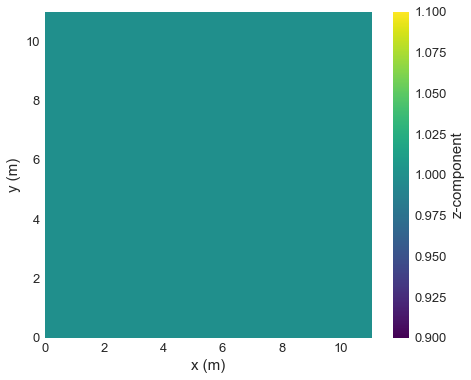

In [295]:
region = df.Region(p1=(0, 0, 0), p2=(11, 11, 11))
mesh = df.Mesh(region=region, cell=(1,1,1))
field = df.Field(mesh=mesh, dim=3, value=(0, 0, 1))
field.plane('z').mpl()

theta_x = np.pi/4
theta_y = np.pi/4
theta_z = np.pi/4

In [269]:
vector = (1,0,0)

In [283]:
#%%timeit
theta_x = theta_z =0
theta_y = np.pi/2
new_field_1 = rotate_field_opt(field, theta_x=theta_x, theta_y=theta_y, theta_z=theta_z, n=(60,60,60))

#theta = np.pi/4
#vector = (0, 1, 0)
#new_field_2 = rotate_field_opt_2(field, theta=theta, vector=vector, n=(10,10,10))

#vector = (0,0,1)
#new_field_3 = rotate_field_opt_3(field, vector=vector, n=(10,10,10))

In [299]:
theta_x = theta_z =0
theta_y = np.pi/2
new_field_90 = rotate_field_opt(field, theta_x=theta_x, theta_y=theta_y, theta_z=theta_z, n=(11,11,11))

theta_y = np.pi/4
new_field_45 = rotate_field_opt(field, theta_x=theta_x, theta_y=theta_y, theta_z=theta_z, n=(11,11,11))
new_field_45 = rotate_field_opt(new_field_45, theta_x=theta_x, theta_y=theta_y, theta_z=theta_z, n=(11,11,11))

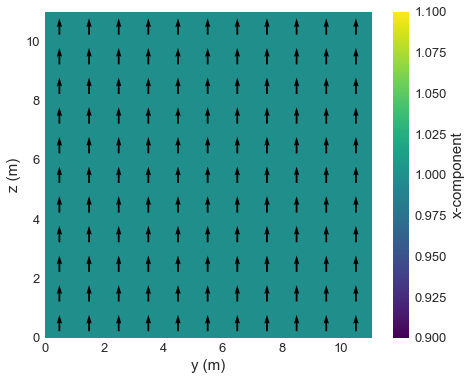

In [300]:
new_field_90.plane('x').mpl()

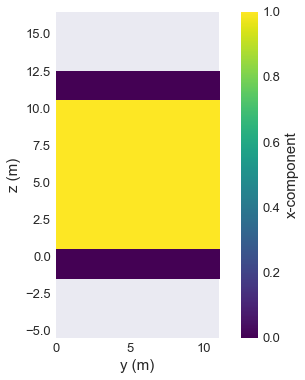

In [302]:
new_field_45.plane('x').mpl()

In [303]:
new_field_45.norm.k3d.nonzero()

Output()

np.allclose(new_field_1.array, new_field_3.array)

In [284]:
new_field_1.mesh

Mesh(region=Region(p1=(-2.0710678118654755, 0.0, -2.0710678118654755), p2=(12.071067811865476, 10.0, 12.071067811865476)), n=(60, 60, 60), bc='', subregions={}, attributes={'unit': 'm', 'fourierspace': False, 'isplane': False})

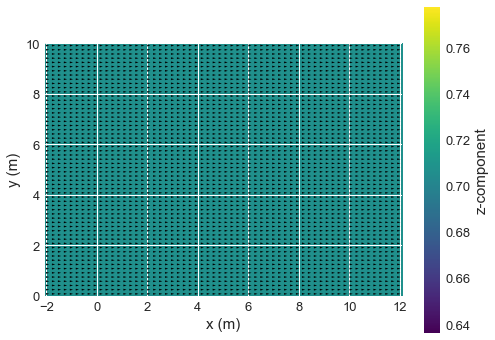

In [285]:
new_field_1.plane('z').mpl()
plt.grid()

In [286]:
new_field_1.k3d.vector()

Output()

In [218]:
new_field_1.norm.k3d.nonzero()

Output()

In [219]:
import matplotlib.pyplot as plt

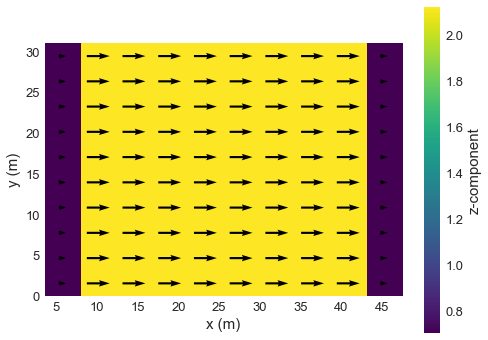

In [220]:
new_field_1.integral('z').mpl()

## Scipy

In [1]:
import numpy as np
from scipy.spatial.transform import Rotation as R

In [2]:
#%%timeit
v1 = [1, 1, 1]
r = R.from_euler('xyz', [90, 0, 0], degrees=True)
v2 = r.apply(v1)

In [3]:
v1 = [1, 1, 1]
r = R.from_euler('xyz', [90, 0, 0], degrees=True)
v2 = r.apply(v1)
v2

array([ 1., -1.,  1.])

In [4]:
r = R.from_euler('xyz', [0, 90, 0], degrees=True)
r.as_matrix()

array([[ 0.,  0.,  1.],
       [ 0.,  1.,  0.],
       [-1.,  0.,  0.]])

## Numpy

In [6]:
np.isclose(R_tot(0, np.pi/2, 0), r.as_matrix()).all()

True

In [7]:
%%timeit
v1 = [1, 1, 1]
v2 = Rot_vector(v1, theta_x=np.pi/2)

29.3 µs ± 2.57 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## Discretised field

### Field rotations

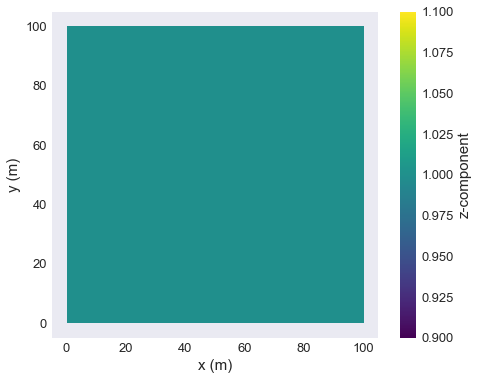

In [164]:
field.pad({'x': (1, 1), 'y': (1, 1), 'z': (1, 1)}, mode='constant').plane('z').mpl()

In [136]:
np.allclose(new_field[region].array, field.pad({'x': (1, 1), 'y': (1, 1), 'z': (1, 1)}, mode='constant').array)

True

## To Do
Create adaptable padding based on rotation angles.

In [189]:
r_matrix = R_tot(0, 0, np.pi/4)
edges = np.array(region.edges)
erx = abs(Rot_vector_mat([edges[0], 0, 0], r_matrix))
ery = abs(Rot_vector_mat([0, edges[1], 0], r_matrix))
erz = abs(Rot_vector_mat([0, 0, edges[2]], r_matrix))
tot_edge_len = erx + ery + erz

In [190]:
erx

array([70.71067812, 70.71067812,  0.        ])

In [180]:
np.array(region.centre) + total_edge_length/2

array([120.71067812, 120.71067812,  10.        ])

In [167]:
r_matrix = R_tot(0, 0, np.pi/4)
Rot_vector_mat(np.array(region.p1)-np.array(region.centre), r_matrix) + np.array(region.centre)

array([ 50.        , -20.71067812,   0.        ])

In [174]:
Rot_vector_mat(np.array(region.p2)-np.array(region.centre), r_matrix) + np.array(region.centre)

array([ 50.        , 120.71067812,  10.        ])

In [170]:
c1 = np.array(region.centre) - [1,1,1]*np.array(region.edges)/2
Rot_vector_mat(c1-np.array(region.centre), r_matrix) + np.array(region.centre)

array([ 50.        , -20.71067812,   0.        ])

In [172]:
c2 = np.array(region.centre) - [-1,1,1]*np.array(region.edges)/2
Rot_vector_mat(c2-np.array(region.centre), r_matrix) + np.array(region.centre)

array([120.71067812,  50.        ,   0.        ])

In [173]:
c2

array([100.,   0.,   0.])

In [84]:
np.linalg.det(R_tot(0, 0, 0))

1.0

In [116]:
np.array(region.centre) - [1,-1,1]*np.array(region.edges)/2

array([  0., 100.,   0.])

In [103]:
np.abs(np.array(region.p2) - np.array(region.p1))

array([100, 100,  10])

In [ ]:
def rotate_field_opt2(field, theta_x=0, theta_y=0, theta_z=0, n=None):
    ### Rotation matrix
    r_matrix = R_tot(theta_x, theta_y, theta_z)
    inv_r_matrix = np.linalg.inv(r_matrix)
    
    ### Rotate Field vectors
    field_rot = rot_loop_mat(field, r_matrix)
    
    ### Create intepolation
    mesh_field = df.Field(mesh=field.mesh, dim=3, value=lambda x: x)
    x = mesh_field.array[:, 0, 0, 0] - field.mesh.region.centre[0]
    y = mesh_field.array[0, :, 0, 1] - field.mesh.region.centre[1]
    z = mesh_field.array[0, 0, :, 2] - field.mesh.region.centre[2]
    mx = field_rot[..., 0]
    my = field_rot[..., 1]
    mz = field_rot[..., 2]
    interp_func_mx = RegularGridInterpolator((x, y, z), mx, fill_value=0.0, bounds_error=False)
    interp_func_my = RegularGridInterpolator((x, y, z), my, fill_value=0.0, bounds_error=False)
    interp_func_mz = RegularGridInterpolator((x, y, z), mz, fill_value=0.0, bounds_error=False)
    
    ### Create new region
    max_dist = np.sqrt((sum(np.array(field.mesh.region.p1)-np.array(field.mesh.region.centre))**2))/np.sqrt(2)  # max lenght from center to corner
    p1_new = field.mesh.region.centre - max_dist
    p2_new = field.mesh.region.centre + max_dist
    new_region = df.Region(p1=p1_new, p2=p2_new)
    
    ### Create new number of cells
    if n is None:
        d_arr = [field.mesh.dx, field.mesh.dy, field.mesh.dz]
        d_arr_rot_x = abs(Rot_vector_mat([mesh.dx, 0, 0], r_matrix))
        d_arr_rot_y = abs(Rot_vector_mat([0, mesh.dy, 0], r_matrix))
        d_arr_rot_z = abs(Rot_vector_mat([0, 0, mesh.dz], r_matrix))
        d_arr_rot = d_arr_rot_x + d_arr_rot_y + d_arr_rot_z
        new_n = np.array([np.ceil(2*max_dist/d_arr_rot[0]).astype(int),
                          np.ceil(2*max_dist/d_arr_rot[1]).astype(int),
                          np.ceil(2*max_dist/d_arr_rot[2]).astype(int)]).tolist()
    else:
        new_n = n
    
    ### Create new mesh
    new_mesh = df.Mesh(region=new_region, n=new_n)
    new_mesh_field = df.Field(mesh=new_mesh, dim=3, value=lambda x: x)
    new_mesh_pos = np.concatenate([new_mesh_field.array[..., 0].flatten()[..., None] - field.mesh.region.centre[0],
                                   new_mesh_field.array[..., 1].flatten()[..., None] - field.mesh.region.centre[1],
                                   new_mesh_field.array[..., 2].flatten()[..., None] - field.mesh.region.centre[2]], axis=1)

    ### Map new mesh onto the old mesh
    new_mp = []
    for mp in new_mesh_pos:
        new_mp.append(inv_Rot_vector_mat(mp, inv_r_matrix))
    new_mp = np.array(new_mp)

    ### Get values of field at new mesh locations
    new_mx = interp_func_mx(new_mp).reshape(new_n)
    new_my = interp_func_my(new_mp).reshape(new_n)
    new_mz = interp_func_mz(new_mp).reshape(new_n)
    new_m = np.stack([new_mx,new_my,new_mz], axis=3)
    
    ### Construct new field
    return df.Field(mesh=new_mesh, dim=3, value=new_m)

In [72]:
def rotate_field(field, theta_x=0, theta_y=0, theta_z=0, n=None):
    ### Rotate Field vectors
    field_rot = rot_field(field, theta_x=theta_x, theta_y=theta_y, theta_z=theta_z)
    
    ### Create intepolation
    mesh_field = df.Field(mesh=field.mesh, dim=3, value=lambda x: x)
    x = mesh_field.array[:, 0, 0, 0]
    y = mesh_field.array[0, :, 0, 1]
    z = mesh_field.array[0, 0, :, 2]
    mx = field_rot.array[..., 0]
    my = field_rot.array[..., 1]
    mz = field_rot.array[..., 2]
    interp_func_mx = RegularGridInterpolator((x, y, z), mx, fill_value=0.0, bounds_error=False)
    interp_func_my = RegularGridInterpolator((x, y, z), my, fill_value=0.0, bounds_error=False)
    interp_func_mz = RegularGridInterpolator((x, y, z), mz, fill_value=0.0, bounds_error=False)
    
    ### Create new region
    max_dist = np.sqrt((sum(np.array(field.mesh.region.p1)-np.array(field.mesh.region.centre))**2)) / 2  # max lenght from center to corner
    p1_new = region.centre - max_dist
    p2_new = region.centre + max_dist
    new_region = df.Region(p1=p1_new, p2=p2_new)
    
    ### Create new number of cells
    if n is None:
        d_arr = [mesh.dx, mesh.dy, mesh.dz]
        d_arr_rot_x = abs(Rot_vector([mesh.dx, 0, 0], theta_x=theta_x, theta_y=theta_y, theta_z=theta_z))
        d_arr_rot_y = abs(Rot_vector([0, mesh.dy, 0], theta_x=theta_x, theta_y=theta_y, theta_z=theta_z))
        d_arr_rot_z = abs(Rot_vector([0, 0, mesh.dz], theta_x=theta_x, theta_y=theta_y, theta_z=theta_z))
        d_arr_rot = d_arr_rot_x + d_arr_rot_y + d_arr_rot_z
        new_n = np.array([np.ceil(2*max_dist/d_arr_rot[0]).astype(int),
                          np.ceil(2*max_dist/d_arr_rot[1]).astype(int),
                          np.ceil(2*max_dist/d_arr_rot[2]).astype(int)]).tolist()
    else:
        new_n = n
    
    ### Create new mesh
    new_mesh = df.Mesh(region=new_region, n=new_n)
    new_mesh_field = df.Field(mesh=new_mesh, dim=3, value=lambda x: x)
    new_mesh_pos = np.concatenate([new_mesh_field.array[..., 0].flatten()[..., None],
                                   new_mesh_field.array[..., 1].flatten()[..., None],
                                   new_mesh_field.array[..., 2].flatten()[..., None]], axis=1)

    ### Map new mesh onto the old mesh
    new_mp = []
    for mp in new_mesh_pos:
        new_mp.append(inv_Rot_vector(mp, theta_x=theta_x, theta_y=theta_y, theta_z=theta_z))
    new_mp = np.array(new_mp)

    ### Get values of field at new mesh locations
    new_mx = interp_func_mx(new_mp).reshape(new_n)
    new_my = interp_func_my(new_mp).reshape(new_n)
    new_mz = interp_func_mz(new_mp).reshape(new_n)
    new_m = np.stack([new_mx,new_my,new_mz], axis=3)
    
    ### Construct new field
    return df.Field(mesh=new_mesh, dim=3, value=new_m)

In [73]:
%%timeit
new_field = rotate_field(field, theta_x=theta_x, theta_y=theta_y, theta_z=theta_z, n=(60,60,60))

KeyboardInterrupt: 